In [1]:
import theano
import theano.tensor as T
import keras


Using gpu device 0: GeForce 940M (CNMeM is disabled, CuDNN not available)


In [2]:
from sklearn.metrics import classification_report

In [3]:
def cat2lab (x):
    '''only for binary category'''
    return [0 if s[0] else 1 for s in x]

In [4]:
print(theano.config)

floatX (('float64', 'float32', 'float16')) 
    Doc:  Default floating-point precision for python casts.

Note: float16 support is experimental, use at your own risk.
    Value:  float32

warn_float64 (('ignore', 'warn', 'raise', 'pdb')) 
    Doc:  Do an action when a tensor variable with float64 dtype is created. They can't be run on the GPU with the current(old) gpu back-end and are slow with gamer GPUs.
    Value:  ignore

cast_policy (('custom', 'numpy+floatX')) 
    Doc:  Rules for implicit type casting
    Value:  custom

int_division (('int', 'raise', 'floatX')) 
    Doc:  What to do when one computes x / y, where both x and y are of integer types
    Value:  int

device (cpu, gpu*, opencl*, cuda*) 
    Doc:  Default device for computations. If gpu*, change the default to try to move computation to it and to put shared variable of float32 on it. Do not use upper case letters, only lower case even if NVIDIA use capital letters.
    Value:  gpu

init_gpu_device (, gpu*, opencl*, c

In [5]:
#np.distutils.__config__.show()

### dram-> vram / bottleneck

In [6]:
x= T.scalar('x',dtype='float64')
compute = theano.function([x], 2*x**2)
compute(2)


array(8.0)

### direct to gpu

In [7]:
x_value = theano.shared(10.0)
compute = theano.function([], 2*x , givens={x:x_value})
compute()

array(20.0)

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.cross_validation import train_test_split
from keras.layers import Convolution2D ,MaxPooling2D,Flatten
from keras.utils import np_utils
from keras import backend as K
import pickle
from keras.callbacks import History,Callback

Using Theano backend.
C:\Users\Back_jud\Anaconda2\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning:

downsample module has been moved to the theano.tensor.signal.pool module.



In [9]:
from keras.layers import LSTM

In [10]:
a = open('d://labels.p')
b = open('d://images.p')
labels = np.array(pickle.load(a))
imgs = np.array(pickle.load(b))
imgs = imgs /255
labels = np_utils.to_categorical(labels,nb_classes=2)


In [11]:
orimgs =[]
for a in imgs:
    orimgs.append(np.reshape(a,(50,50))) 

In [12]:
x_tr,x_te,y_tr,y_te = train_test_split(orimgs,labels,test_size= 0.2,random_state= 123)

In [13]:
x_tr1,x_te1,y_tr1,y_te1 = train_test_split(imgs,labels,test_size= 0.2,random_state= 123)

## Simple neuron1

In [75]:
model1 = Sequential()
model1.add(Dense(500, input_dim=2500,init ='uniform'))
model1.add(Activation('relu'))
model1.add(Dense(2, activation="softmax"))
model1.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01,decay= 1e-6,momentum=0.9,nesterov=True))

In [76]:
%time hist1 = model1.fit(np.array(x_tr1), np.array(y_tr1), nb_epoch=300,validation_split=0.1 ,batch_size=50,show_accuracy=True,verbose=0)

Wall time: 7.95 s


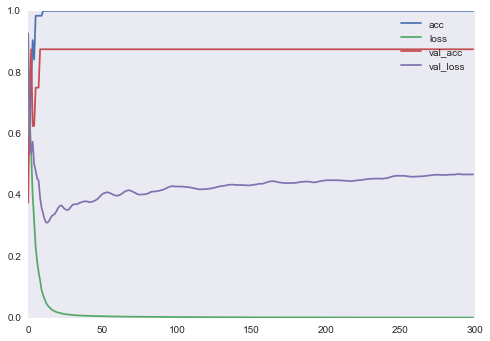

In [77]:
plt.plot(hist1.history['acc'],label='acc')
plt.plot(hist1.history['loss'],label='loss')
plt.plot(hist1.history['val_acc'],label='val_acc')
plt.plot(hist1.history['val_loss'],label='val_loss')
plt.grid('off')
plt.legend()

In [78]:
model1.evaluate(np.array(x_te1),y_te1,batch_size=50,show_accuracy=True)

18/18 [==============================] - 0s


[1.8439598083496094, 0.66666666666666663]

In [18]:
model1.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 2500)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Dense (dense)                 (None, 50)                    125050              
Activation (activation)       (None, 50)                    0                   
Dense (dense)                 (None, 2)                     102                 
--------------------------------------------------------------------------------
Total params: 125152
--------------------------------------------------------------------------------


In [19]:
y_pred1 = model1.predict_classes(np.array(x_te1),20)

18/18 [==============================] - 0s


In [20]:
y_ten1 = cat2lab(y_te1)

In [21]:
print(classification_report(y_ten1,y_pred1))

             precision    recall  f1-score   support

          0       0.75      0.60      0.67        10
          1       0.60      0.75      0.67         8

avg / total       0.68      0.67      0.67        18



In [22]:
d= model1.get_weights()[0]

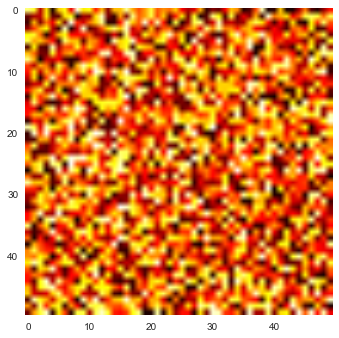

In [23]:
plt.imshow(np.reshape(d[:,4],(50,50)),cmap='hot')
plt.grid('off')

In [24]:
#imgs for CNN
imgs2d= []
for img in imgs:
    imgs2d.append(np.reshape(img,(1,50,50)))


In [25]:
x_tr2,x_te2,y_tr2,y_te2 = train_test_split(imgs2d,labels,test_size= 0.2,random_state= 194)

In [284]:
model2 = Sequential()
history2 = History()
model2.add(Convolution2D(10,10, 10, border_mode='same', input_shape=(1, 50, 50)))
model2.add(Activation('relu'))
# model2.add(Convolution2D(50, 5, 5,init='uniform'))
# model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Convolution2D(10, 10, 10,init='uniform' ,border_mode='same'))
model2.add(Activation('relu'))
# model2.add(Convolution2D(100, 5, 5,init='uniform'))
# model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(1250,init='uniform'))
model2.add(Activation('relu'))
model2.add(Dense(2,activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01,
                                                              decay=1e-6,
                                                              momentum=0.9, 
                                                              nesterov=True))

INFO (theano.gof.compilelock): Refreshing lock C:\Users\Back_jud\AppData\Local\Theano\compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64\lock_dir\lock
INFO:theano.gof.compilelock:Refreshing lock C:\Users\Back_jud\AppData\Local\Theano\compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64\lock_dir\lock


In [285]:
%time hist2 = model2.fit(np.array(x_tr2), y_tr2, nb_epoch=50 , batch_size=36 ,validation_split=0.2, show_accuracy=True , shuffle=True,callbacks=[history2])

Train on 56 samples, validate on 15 samples
Epoch 1/50
56/56 [==============================] - 0s - loss: 0.7139 - acc: 0.5000 - val_loss: 0.6322 - val_acc: 0.6000
Epoch 2/50
56/56 [==============================] - 0s - loss: 0.8049 - acc: 0.4821 - val_loss: 0.9862 - val_acc: 0.6000
Epoch 3/50
56/56 [==============================] - 0s - loss: 1.1556 - acc: 0.5179 - val_loss: 0.6994 - val_acc: 0.4667
Epoch 4/50
56/56 [==============================] - 0s - loss: 0.6678 - acc: 0.6786 - val_loss: 0.6896 - val_acc: 0.5333
Epoch 5/50
56/56 [==============================] - 0s - loss: 0.6580 - acc: 0.6429 - val_loss: 0.6621 - val_acc: 0.6667
Epoch 6/50
56/56 [==============================] - 0s - loss: 0.6427 - acc: 0.6786 - val_loss: 0.6329 - val_acc: 0.6667
Epoch 7/50
56/56 [==============================] - 0s - loss: 0.5955 - acc: 0.7857 - val_loss: 0.6045 - val_acc: 0.8667
Epoch 8/50
56/56 [==============================] - 0s - loss: 0.5480 - acc: 0.7857 - val_loss: 0.5319 - val_

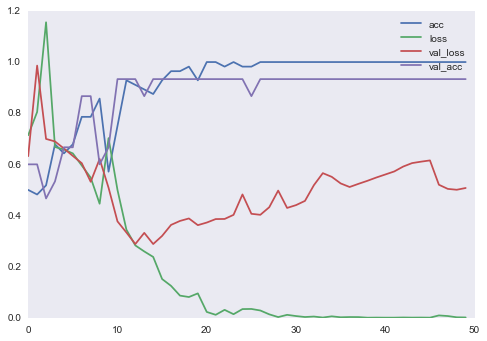

In [286]:
plt.plot(hist2.history['acc'],label='acc')
plt.plot(hist2.history['loss'],label='loss')
plt.plot(hist2.history['val_loss'],label='val_loss')
plt.plot(hist2.history['val_acc'],label='val_acc')
plt.legend()
plt.grid('off')

In [287]:
m2_wegh =  model2.get_weights()

In [288]:
np.shape(m2_wegh[0][0])

(1L, 10L, 10L)

In [360]:
def plot_wegh (wegh_arr):
    num = len(m2_wegh[0])
    col = int(num/2)
    row = int(num/col) 
    
    fig ,axes = plt.subplots(row,col, subplot_kw={'xticks': [], 'yticks': []})
    plt.subplots_adjust(hspace=0.02,wspace = 0.05)
    

    for i, ax in zip(xrange(num),axes.flat):
        
        ax.imshow(m2_wegh[0][i][0])
        ax.grid('off')
     

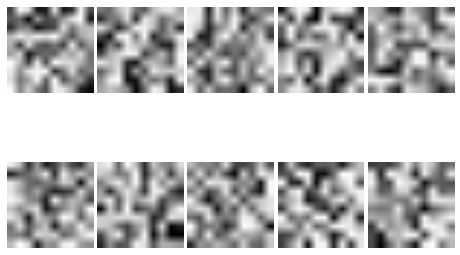

In [361]:
plot_wegh(m2_wegh)

In [353]:
for a in m2_wegh:
    print(np.shape(a))
    #     print(len(a))

(10L, 1L, 10L, 10L)
(10L,)
(10L, 10L, 10L, 10L)
(10L,)
(1440L, 1250L)
(1250L,)
(1250L, 2L)
(2L,)


In [291]:
model2.evaluate(np.array(x_te2),y_te2,batch_size=15,show_accuracy=True)

18/18 [==============================] - 0s     


[0.01226499120699979, 1.0]

In [292]:
y_pred2 = model2.predict_classes(np.array(x_te2))

18/18 [==============================] - 0s


In [293]:
y_ten2 = [0 if s[0] else 1 for s in y_te2]

In [294]:
cr = classification_report(y_ten2,y_pred2)

In [295]:
print(cr)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         6
          1       1.00      1.00      1.00        12

avg / total       1.00      1.00      1.00        18



In [244]:
#!start c:\users\back_jud\anaconda2\lib\site-packages\keras\layers\

In [38]:
model3 = Sequential()
history3 = History()
model3.add(Convolution2D(50,5, 5, border_mode='same',init='uniform',activation='relu' ,input_shape=(1, 50, 50)))
# model3.add(Convolution2D(50, 5, 5,,activation='logistic' ,init='uniform'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.50))

# model3.add(Convolution2D(100, 5, 5, border_mode='same'))
# model3.add(Activation('LSTM'))
# model3.add(Convolution2D(100, 5, 5,init='uniform'))
# model3.add(Activation('LSTM'))
# model3.add(MaxPooling2D(pool_size=(2, 2)))
# model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(1250,init='uniform'))
model3.add(Activation('relu'))
model3.add(Dense(2,activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

In [39]:
%time hist3 = model3.fit(np.array(x_tr2), y_tr2, nb_epoch=50 , batch_size=36 ,validation_split=0.2, show_accuracy=True , shuffle=True,callbacks=[history3])

Train on 56 samples, validate on 15 samples
Epoch 1/50
56/56 [==============================] - 0s - loss: 0.6728 - acc: 0.5179 - val_loss: 0.6560 - val_acc: 0.6000
Epoch 2/50
56/56 [==============================] - 0s - loss: 0.6783 - acc: 0.5179 - val_loss: 0.7113 - val_acc: 0.4000
Epoch 3/50
56/56 [==============================] - 0s - loss: 0.6405 - acc: 0.6071 - val_loss: 0.6458 - val_acc: 0.5333
Epoch 4/50
56/56 [==============================] - 0s - loss: 0.5624 - acc: 0.7857 - val_loss: 0.5863 - val_acc: 0.8667
Epoch 5/50
56/56 [==============================] - 0s - loss: 0.5463 - acc: 0.8214 - val_loss: 0.5822 - val_acc: 0.8667
Epoch 6/50
56/56 [==============================] - 0s - loss: 0.5143 - acc: 0.7321 - val_loss: 0.8044 - val_acc: 0.4000
Epoch 7/50
56/56 [==============================] - 0s - loss: 0.6423 - acc: 0.5893 - val_loss: 1.3924 - val_acc: 0.4000
Epoch 8/50
56/56 [==============================] - 0s - loss: 0.7310 - acc: 0.6071 - val_loss: 0.4910 - val_

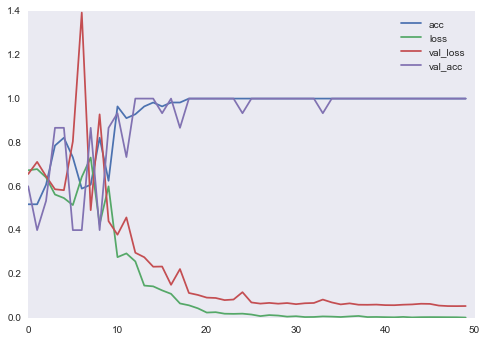

In [40]:
plt.plot(hist3.history['acc'],label='acc')
plt.plot(hist3.history['loss'],label='loss')
plt.plot(hist3.history['val_loss'],label='val_loss')
plt.plot(hist3.history['val_acc'],label='val_acc')
plt.legend()
plt.grid('off')

In [41]:
model3.evaluate(np.array(x_te2),y_te2,show_accuracy=True)

18/18 [==============================] - 0s


[0.16132007539272308, 0.88888888888888884]

In [42]:
y_pred3 = model3.predict_classes(np.array(x_te2))

18/18 [==============================] - 0s


In [43]:
model3.evaluate(np.array(x_te2),y_te2,batch_size=36,show_accuracy=True)

18/18 [==============================] - 0s


[0.16132007539272308, 0.88888888888888884]

In [44]:
print(classification_report(y_ten2,y_pred3))

             precision    recall  f1-score   support

          0       0.75      1.00      0.86         6
          1       1.00      0.83      0.91        12

avg / total       0.92      0.89      0.89        18



In [45]:
model3.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 1, 50, 50)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Convolution2D (convolution2d) (None, 50, 50, 50)            1300                
MaxPooling2D (maxpooling2d)   (None, 50, 25, 25)            0                   
Dropout (dropout)             (None, 50, 25, 25)            0                   
Flatten (flatten)             (None, 31250)                 0                   
Dense (dense)                 (None, 1250)                  39063750            
Activation (activation)       (None, 1250)                  0                   
Dense (dense)                 (None, 2)                     2502                
----------------------------------------------------------------------

In [46]:
y_pred3

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0], dtype=int64)

In [47]:
y_ten2

[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0]

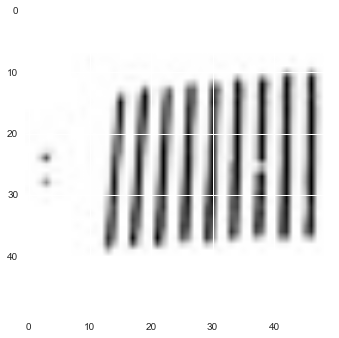

In [48]:
plt.imshow(np.reshape(x_tr2[-5],(50,50)))

## SVM

### sample수 부족??? 

In [49]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC

In [50]:
params4 = {'C' : [1e1, 1e2, 1e3,1e4,1e5],
           'gamma' : [0.0001,0.0005,0.001,0.005,0.01]}

In [51]:
clf = GridSearchCV(SVC(kernel='rbf'),params4)

In [52]:
y_trn4 = cat2lab(y_tr1)
model4 = clf.fit(x_tr1,y_trn4)

In [53]:
model4.score(x_te1,cat2lab(y_te1))

0.77777777777777779

In [54]:
model4.best_score_ ,model4.best_params_

(0.84507042253521125, {'C': 10.0, 'gamma': 0.01})

In [55]:
y_pred4 = model4.predict(x_te1)
y_pred4

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1])

In [56]:
y_ten4 = cat2lab(y_te1)
y_ten4

[1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0]

In [57]:
print(classification_report(y_ten4,y_pred4))

             precision    recall  f1-score   support

          0       1.00      0.60      0.75        10
          1       0.67      1.00      0.80         8

avg / total       0.85      0.78      0.77        18



In [58]:
import pywt

In [59]:
Ca,Cd = pywt.dwt2(x_tr[25],'haar')

In [60]:
np.shape(Ca)

(25L, 25L)

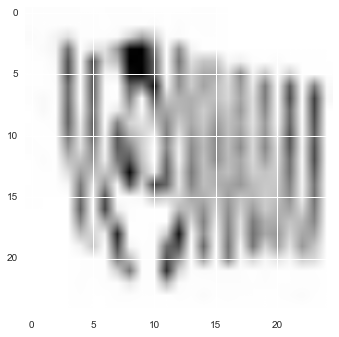

In [61]:
plt.imshow(Ca)

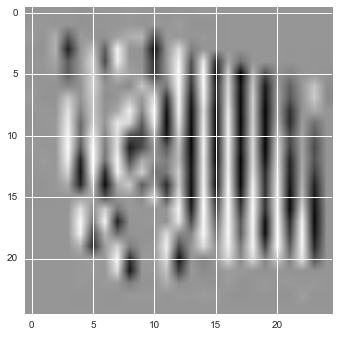

In [62]:
plt.imshow(Cd[1])

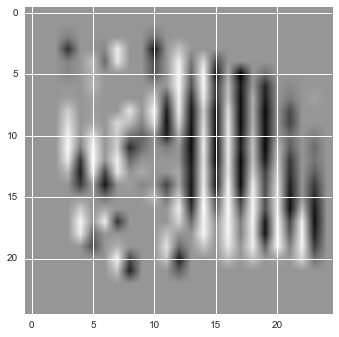

In [63]:
plt.imshow(pywt.threshold(Cd[1],0.3))

In [64]:
from cv2 import HoughLines
from cv2 import HoughLinesP
import cv2

In [65]:
from os import listdir

In [66]:
asdf = listdir('d://nor/')

In [88]:
ima = cv2.imread('d://nor/'+asdf[1],1)

In [133]:
imb = cv2.Canny(ima,100,250)

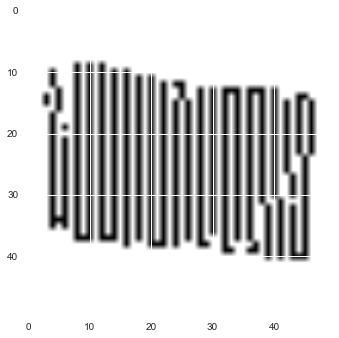

In [134]:
plt.imshow(imb)